In [1]:
import string
import re
import os
import nltk
import pandas as pd
import numpy as np
import json
import tensorflow as tf
from tensorflow import keras
SEED = 1013
np.random.seed(SEED)
#nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords, twitter_samples 
from stance_utils import *
#from parameters import *
from nltk.stem import PorterStemmer
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
#from tensorflow.keras.layers import Dropout,Concatenate,Dense, Embedding, SpatialDropout1D, Flatten, GRU, Bidirectional, Conv1D,MaxPooling1D

from tensorflow.keras.layers import RNN, Dropout,Concatenate,Dense, Embedding,LSTMCell, LSTM, SpatialDropout1D, Flatten, GRU, Bidirectional, Conv1D, Input,MaxPooling1D
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model
from sklearn.model_selection import StratifiedKFold
stemmer = PorterStemmer()
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
stopwords_english = stopwords.words('english')
from sklearn.preprocessing import LabelEncoder
import keras.backend as K
from keras.layers import Lambda
import random
import matplotlib.pyplot as plt

In [2]:
classes = {'FAVOR': np.array([1, 0, 0]), 'AGAINST': np.array([0, 1, 0]), 'NONE': np.array([0, 0, 1])}
classes_ = np.array(['FAVOR', 'AGAINST', 'NONE'])
models = ['bicond', 'biLSTM', 'biLSTMCNN', 'biGRU', 'biGRUCNN']

In [3]:
batch_size = 16
setting = 'in' #'in' or 'cross'
units = 60
model = 'biLSTM'

In [4]:
train_data_file_m = '/data/parush/stance_mohammed/train.txt'
test_data_file_m = '/data/parush/stance_mohammed/test.txt'
TARGETS_m = [ 'Atheism','Climate Change is a Real Concern', 'Feminist Movement','Hillary Clinton', 'Legalization of Abortion' ]

In [5]:
def train_and_test(train_file, test_file, target):
    
    sentence_maxlen = 0
    target_maxlen = 0
    x_s_token = []
    x_t_token = []
    y_train = []

    
    with open(train_file, 'r') as trainfile:
        for line in trainfile: 
            line = line.replace('#SemST', '').strip()
            line = line.split('\t')
            
            
            if line[0].strip() != 'ID' and target in line[1].strip():
                tweet = line[2]
                tweet = process_tweet(tweet)
                if len(tweet) > sentence_maxlen:
                    sentence_maxlen = len(tweet)
                x_s_token.append(tweet)
                target_ = line[1].strip().lower().split()
                if len(target_) > target_maxlen:
                    target_maxlen = len(target_)
                x_t_token.append(target_)
                y_train.append(classes[line[3].strip()])
    

                               
    
    x_s_test_token = []
    x_t_test_token = []
    y_test = []
    with open(test_file, 'r') as testfile:
        for line in testfile:
            line = line.replace('#SemST', '').strip()
            line = line.split('\t')
        

            
            if line[0] != 'ID' and target in line[1].strip():
                tweet = line[2]
                tweet = process_tweet(tweet)
                if len(tweet) > sentence_maxlen:
                    sentence_maxlen = len(tweet)
                x_s_test_token.append(tweet)
                target_ = line[1].strip().lower().split()
                if len(target_) > target_maxlen:
                    target_maxlen = len(target_)
                x_t_test_token.append(target_)
                y_test.append(classes[line[3].strip()])


    
    return x_s_token, x_t_token, x_s_test_token, x_t_test_token, y_train, y_test, sentence_maxlen, target_maxlen

In [6]:
if setting == 'in':
    x_s_token, x_t_token, x_s_test_token, x_t_test_token, y_train, y_test, sentence_maxlen, target_maxlen  = train_and_test(train_data_file_m, test_data_file_m, TARGETS_m[2])
if setting == 'cross':
    x_s_token, x_t_token, _, _, y_train, _, sentence_maxlen, target_maxlen  = train_and_test(train_data_file_m, test_data_file_m, TARGETS_m[2])
    _, _, x_s_test_token, x_t_test_token, _, y_test, _, _  = train_and_test(train_data_file_m, test_data_file_m, TARGETS_m[4])
    

In [7]:
vocabulary = build_vocab(x_s_token + x_t_token )
vocab_size = len(vocabulary)
print("Total words in vocab are",vocab_size)

Total words in vocab are 2349


In [8]:
if model == 'bicond':
    y_train = np.asarray(y_train)
    _,balance = divmod(len(y_train),batch_size)
    print(_,balance)
    print(len(y_train))
    n_splits=len(y_train)//balance
    print(n_splits)
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    for train_index, test_index in kfold.split(x_s_token, classes_[y_train.argmax(1)]):
        test_index = test_index
        break
    y_train = list(y_train)
    test_index = list(test_index)
    for i in test_index:
        x_s_token.append(x_s_token[i])
        y_train.append(y_train[i])
        x_t_token.append(x_t_token[i])
    

In [9]:
x_s = [tweet_to_tensor(each_s,vocabulary) for each_s in x_s_token]
x_s = pad_sequences(x_s, maxlen = sentence_maxlen, padding = 'post')
x_s_test = [tweet_to_tensor(each_s,vocabulary) for each_s in x_s_test_token]
x_s_test = pad_sequences(x_s_test, maxlen = sentence_maxlen, padding = 'post')

x_t = [tweet_to_tensor(each_s,vocabulary) for each_s in x_t_token]
x_t = pad_sequences(x_t, maxlen = sentence_maxlen, padding = 'post')
x_t_test = [tweet_to_tensor(each_s,vocabulary) for each_s in x_t_test_token]
x_t_test = pad_sequences(x_t_test, maxlen = sentence_maxlen, padding = 'post')

In [10]:
shuffle_indices = np.random.permutation(np.arange(len(y_train)))
x_s = x_s[shuffle_indices]
x_t = x_t[shuffle_indices]
y_train = np.asarray(y_train)
y_train = y_train[shuffle_indices]
y_test = np.asarray(y_test)


In [11]:
embedding_matrix = get_embeddings('twitter',100,vocabulary)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [14]:

opt = keras.optimizers.Adam(learning_rate=1e-3)
num_classes = 3


def bicond(units,inputs,opt, embedding_matrix, x_t):
    embedded_inputs = tf.nn.embedding_lookup(embedding_matrix, x_t)
    print(embedded_inputs.shape)
    inputs = embedded_inputs[:batch_size]
    
    h_0 = tf.convert_to_tensor(np.zeros([batch_size, units]).astype(np.float32))
    c_0 = tf.convert_to_tensor(np.zeros([batch_size, units]).astype(np.float32))
    start_state = [h_0, c_0]
    lstm = LSTM(units, return_sequences=True, return_state=True)
    fw_output, fw_h_0, fw_c_0 = lstm(inputs,initial_state = [h_0, c_0])
    bw_output, bw_h_0, bw_c_0 = lstm(inputs[::-1],initial_state = [h_0, c_0]) # feeding data backwords
    
    inputs2 = Input(shape=(sentence_maxlen), name = 'Input')
    embedded_inputs = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights=[embedding_matrix], name = 'Embedding')(inputs2)
    lstm = LSTM(units,activation='tanh',dropout=0.1,name = 'lstm')(embedded_inputs, initial_state = [h_0, fw_c_0])
    b_lstm = LSTM(units,activation='tanh',dropout=0.1, go_backwards = True,name = 'back_lstm')(embedded_inputs, initial_state = [h_0, bw_c_0])
    cond_out = []
    cond_out.append(lstm)
    cond_out.append(b_lstm)
    concat_output = Concatenate()(cond_out)
    flat = Flatten(name = 'Flatten')(concat_output)
    output = (Dense(3,activation='softmax',name = 'Dense'))(flat)
    model = Model(inputs=inputs2, outputs=output)
    model.compile(loss = 'categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])    
    model.summary()
    
    return model

def biLSTM():
    model = Sequential()
    model.add(Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights=[embedding_matrix]))
    model.add(Dropout(0.2))
    model.add(LSTM(64,return_sequences=True,dropout=0.3))
    model.add(Bidirectional(LSTM(64,dropout=0.3)))
    #model.add(Flatten())
    #add a dropout here
    model.add(Dropout(0.5))
    model.add(Dense(num_classes,activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
    return model

def biLSTMCNN():
    inputs = Input(shape=(sentence_maxlen,))
    embedded_inputs = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights=[embedding_matrix])(inputs)
    embedded_inputs = Dropout(0.2)(embedded_inputs)
    lstm = Bidirectional(LSTM(64,return_sequences=True,dropout=0.3))(embedded_inputs)
    convs = []
    for each_filter_size in [3,4,5]:
        #print(rnn.shape)
        each_conv = Conv1D(100, each_filter_size, activation='relu')(lstm)
        each_conv = MaxPooling1D(sentence_maxlen-each_filter_size+1)(each_conv)
        each_conv = Flatten()(each_conv)
        #print(each_conv.shape)
        convs.append(each_conv)
        
    output = Concatenate()(convs)
    output = Dropout(0.5)(output)
    output = (Dense(3,activation='softmax'))(output)
    model = Model(inputs=inputs, outputs=output)
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy']) 
    return model

def biGRU():
    model = Sequential()
    model.add(Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights=[embedding_matrix]))
    model.add(Dropout(0.2))
    model.add(Bidirectional(GRU(64,return_sequences=True,dropout=0.3)))
    model.add(Bidirectional(GRU(64,dropout=0.3)))
    model.add(Dropout(0.5))
    model.add(Dense(3,activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
    return model

def biGRUCNN():
    inputs = Input(shape=(sentence_maxlen,))
    embedded_inputs = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights=[embedding_matrix])(inputs)
    embedded_inputs = Dropout(0.2)(embedded_inputs)
    rnn = Bidirectional(GRU(64,return_sequences=True,dropout=0.3))(embedded_inputs)
    convs = []
    for each_filter_size in [3,4,5]:
        #print(rnn.shape)
        each_conv = Conv1D(100, each_filter_size, activation='relu')(rnn)
        each_conv = MaxPooling1D(sentence_maxlen-each_filter_size+1)(each_conv)
        each_conv = Flatten()(each_conv)
        #print(each_conv.shape)
        convs.append(each_conv)
        
    output = Concatenate()(convs)
    output = Dropout(0.5)(output)
    output = (Dense(3,activation='softmax'))(output)
    model = Model(inputs=inputs, outputs=output)
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])    
    
    return model
    
    
    

In [19]:
model = biLSTM()

In [20]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         234900    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 64)          42240     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 343,575
Trainable params: 343,575
Non-trainable params: 0
________________________________________________

In [21]:
if model == 'bicond':
    v_num = len(y_train)//10 
    _, b3 = divmod(v_num,16)
    v_split = (v_num  + (batch_size-b3)) / len(y_train)
    history = model2.fit(x_s, y_train, epochs = 50, batch_size = batch_size,validation_split = v_split,  verbose=1)
    l = len(x_s_test)
    _, balance2 = divmod(l,batch_size)
    x_s_test = list(x_s_test)
    fill_number = batch_size - balance2
    for i in range(fill_number):
        x_s_test.append(np.zeros(sentence_maxlen,))
        print(len(x_s_test))
    x_s_test = np.array(x_s_test)
    y_pred = np.round(model2.predict(x_s_test, batch_size = 16))
    print(classification_report(y_test, y_pred[:-fill_number], digits=4, labels = [0,1]))
else:
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    cvscores = []

    for train, val in kfold.split(x_s, classes_[y_train.argmax(1)]):
        history = model.fit(x_s[train], y_train[train], epochs = 50, batch_size = batch_size, verbose=1)
        scores = model.evaluate(x_s[val], y_train[val], verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
    print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

    y_pred = np.round(model.predict(x_s_test))
    print(classification_report(y_test, y_pred, digits=4, labels = [0,1]))



Epoch 1/50
34/34 [==============================] - 5s 18ms/step - loss: 1.0369 - accuracy: 0.4689
Epoch 2/50
34/34 [==============================] - 1s 17ms/step - loss: 0.9621 - accuracy: 0.5009
Epoch 3/50
34/34 [==============================] - 1s 17ms/step - loss: 0.8950 - accuracy: 0.5480
Epoch 4/50
34/34 [==============================] - 1s 17ms/step - loss: 0.8099 - accuracy: 0.6215
Epoch 5/50
34/34 [==============================] - 1s 16ms/step - loss: 0.7191 - accuracy: 0.6723
Epoch 6/50
34/34 [==============================] - 1s 16ms/step - loss: 0.5984 - accuracy: 0.7608
Epoch 7/50
34/34 [==============================] - 1s 16ms/step - loss: 0.5639 - accuracy: 0.7589
Epoch 8/50
34/34 [==============================] - 1s 16ms/step - loss: 0.4789 - accuracy: 0.8343
Epoch 9/50
34/34 [==============================] - 1s 16ms/step - loss: 0.3732 - accuracy: 0.8606
Epoch 10/50
34/34 [==============================] - 1s 16ms/step - loss: 0.3319 - accuracy: 0.8814
Epoch 11/

34/34 [==============================] - 1s 17ms/step - loss: 0.0109 - accuracy: 0.9962
Epoch 33/50
34/34 [==============================] - 1s 16ms/step - loss: 0.0465 - accuracy: 0.9793
Epoch 34/50
34/34 [==============================] - 1s 17ms/step - loss: 0.0073 - accuracy: 0.9962
Epoch 35/50
34/34 [==============================] - 1s 16ms/step - loss: 0.0360 - accuracy: 0.9887
Epoch 36/50
34/34 [==============================] - 1s 17ms/step - loss: 0.0285 - accuracy: 0.9925
Epoch 37/50
34/34 [==============================] - 1s 16ms/step - loss: 0.0052 - accuracy: 1.0000
Epoch 38/50
34/34 [==============================] - 1s 17ms/step - loss: 0.0146 - accuracy: 0.9925
Epoch 39/50
34/34 [==============================] - 1s 16ms/step - loss: 0.0162 - accuracy: 0.9981
Epoch 40/50
34/34 [==============================] - 1s 17ms/step - loss: 0.0027 - accuracy: 1.0000
Epoch 41/50
34/34 [==============================] - 1s 16ms/step - loss: 0.0106 - accuracy: 0.9962
Epoch 42/50


34/34 [==============================] - 1s 17ms/step - loss: 0.0183 - accuracy: 0.9962
Epoch 14/50
34/34 [==============================] - 1s 16ms/step - loss: 0.0416 - accuracy: 0.9944
Epoch 15/50
34/34 [==============================] - 1s 16ms/step - loss: 0.0274 - accuracy: 0.9925
Epoch 16/50
34/34 [==============================] - 1s 17ms/step - loss: 0.0151 - accuracy: 0.9962
Epoch 17/50
34/34 [==============================] - 1s 17ms/step - loss: 0.0144 - accuracy: 0.9962
Epoch 18/50
34/34 [==============================] - 1s 17ms/step - loss: 0.0181 - accuracy: 0.9962
Epoch 19/50
34/34 [==============================] - 1s 17ms/step - loss: 0.0123 - accuracy: 0.9962
Epoch 20/50
34/34 [==============================] - 1s 16ms/step - loss: 0.0051 - accuracy: 0.9962
Epoch 21/50
34/34 [==============================] - 1s 17ms/step - loss: 0.0038 - accuracy: 0.9981
Epoch 22/50
34/34 [==============================] - 1s 17ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 23/50


Epoch 44/50
34/34 [==============================] - 1s 16ms/step - loss: 7.0653e-04 - accuracy: 1.0000
Epoch 45/50
34/34 [==============================] - 1s 16ms/step - loss: 1.3217e-04 - accuracy: 1.0000
Epoch 46/50
34/34 [==============================] - 1s 17ms/step - loss: 1.5501e-04 - accuracy: 1.0000
Epoch 47/50
34/34 [==============================] - 1s 17ms/step - loss: 0.0023 - accuracy: 0.9981
Epoch 48/50
34/34 [==============================] - 1s 16ms/step - loss: 0.0172 - accuracy: 0.9962
Epoch 49/50
34/34 [==============================] - 1s 17ms/step - loss: 0.0060 - accuracy: 0.9981
Epoch 50/50
34/34 [==============================] - 1s 16ms/step - loss: 1.8528e-04 - accuracy: 1.0000
accuracy: 100.00%
91.28% (+/- 17.44%)


NameError: name 'x_test' is not defined

In [26]:
history.history

{'loss': [0.0035927877761423588,
  0.008204442448914051,
  0.006231089122593403,
  0.0003763023123610765,
  0.005769252777099609,
  0.010172639973461628,
  0.0065615298226475716,
  0.0003535440191626549,
  0.006791478022933006,
  0.014845076017081738,
  0.02059875801205635,
  0.029959039762616158,
  0.01273314654827118,
  0.0022979143541306257,
  0.0021398647222667933,
  0.0034309879411011934,
  0.006872234400361776,
  0.005735727958381176,
  0.01399385929107666,
  0.0015390785411000252,
  0.01899588108062744,
  0.0025517733301967382,
  0.001054246909916401,
  0.023260589689016342,
  0.0013967665145173669,
  0.0010156385833397508,
  0.000495931482873857,
  0.0004900253843516111,
  0.0003242444072384387,
  0.0003996866289526224,
  0.0003500333405099809,
  0.00019044360669795424,
  0.00022568387794308364,
  0.0001400576438754797,
  0.003306981176137924,
  0.00207971828058362,
  0.0010317051783204079,
  0.00014778516197111458,
  0.00023810444690752774,
  0.0010248557664453983,
  0.0053993

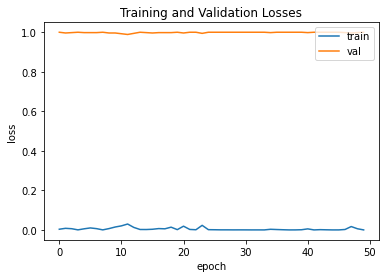

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Losses',size = 12)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

              precision    recall  f1-score   support

           0     0.2778    0.3261    0.3000        46
           1     0.6977    0.4762    0.5660       189

   micro avg     0.5738    0.4468    0.5024       235
   macro avg     0.4877    0.4011    0.4330       235
weighted avg     0.6155    0.4468    0.5140       235
 samples avg     0.3750    0.3750    0.3750       235



/home/p/parush/.conda/envs/nlp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/p/parush/.conda/envs/nlp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
# cvscores = []

# for train, val in kfold.split(x_s, classes_[y_train.argmax(1)]): 
#     model2.fit(x_s[train], y_train[train], epochs = 5, batch_size = 16, verbose=1)
# #     scores = model2.evaluate(x_s[val], y_train[val], verbose=0)
# #     print("%s: %.2f%%" % (model2.metrics_names[1], scores[1]*100))
# #     cvscores.append(scores[1] * 100)
# # print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))





In [ ]:
#embeddings_weights = get_embeddings('wikipedia',300,vocabulary)


In [ ]:
# Do we have to do this?
# x_s_ = tf.convert_to_tensor(
#     x_s_, dtype=tf.float32, dtype_hint=None, name=None
# )

In [ ]:
# i = 0
# j = 16
# while j<=640:
#     inputs = x_t[i:j]
#     lstm = LSTM(128, return_sequences=True, return_state=True)
#     whole_seq_output, h_0, c_0 = lstm(inputs,initial_state = [h_0, c_0])
#     i += 16
#     j += 16



In [ ]:
# inputs = Input(batch_shape=(16,1,18))
# lstm = LSTM(128, return_sequences=True, return_state=True)
# whole_seq_output, h_0, c_0 = lstm(inputs)
# model = Model(inputs=inputs, outputs=whole_seq_output)
# k = model.predict(x_t[:640])

In [ ]:
# final_memory_state = tf.reshape(
#     final_memory_state, (16,1,128), name=None
# )

# final_carry_state = tf.reshape(
#     final_carry_state, (16,1,128), name=None
# )


In [ ]:

# inputs2 = Input(shape=(1,sentence_maxlen,), name = 'Input')
# #embedded_inputs = Embedding(embeddings_weights.shape[0], embeddings_weights.shape[1], weights=[embeddings_weights], name = 'Embedding')(inputs2)
# #embedded_inputs2 = Dropout(0.2)(embedded_inputs)
# lstm, s1,s2 = LSTM(128,return_sequences=True,return_state=True,dropout=0.3,name = 'lstm')(inputs2, initial_state = i_states)
# #lstm = LSTM(128,return_sequences=True,dropout=0.3,name = 'lstm')(inputs2)
# flat = Flatten(name = 'Flatten')(lstm)
# output = (Dense(3,activation='softmax',name = 'Dense'))(flat)
# model2 = Model(inputs=inputs2, outputs=output)
# model2.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])    
# model2.summary()


In [ ]:
# x_t =np.array( [x.reshape(1,18) for x in x_t[:640]])

# x_t = tf.convert_to_tensor(
#     x_t, dtype=tf.float32, dtype_hint=None, name=None
# )

# inputs_list = [tf.squeeze(x) for x in
#                 tf.split(1, sentence_maxlen, embedded_inputs)]